In [1]:
%load_ext autoreload
%autoreload 3 --print

In [32]:
import torch as th
import numpy as np
import numpy.linalg as la
from torch import optim
from torch import nn
from dynrn.rnntasks import DriscollTasks, ExpMin, Uniform
import dynrn.basic_rnns as rnns
from dynrn.viz import util as vu
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import scipy.stats
from pathlib import Path
import tqdm
import seaborn as sns

In [106]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
t20 = lambda x: getc(f"seaborn:tab20{x}")
colors, plotter = styles.init_plt(
    '../plots/notebook/fp-manifolds',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

#### test systems

In [4]:
def ringattract(alpha):
    """
    g(x) = -\nabla (||x||^2- 1) ^ 2 / 2
    f(x) = x + alpha g(x)
    """
    def f(x):
        rad = (x ** 2).sum(axis = -1, keepdims = True)
        return x - alpha * ((rad - 1) * x) ** 1/3
    return f
    

def vectorfield(ax, x0, x1, scale = 0.1, normalize = False, line_kws = {}, pt_kws = {}, **kws):
    ds = x1 - x0
    if normalize:
        ds /= la.norm(ds, axis = -1, keepdims=True)
    ds *= scale
    x0 = x0.reshape(-1, x0.shape[-1])
    x1 = x0 + ds.reshape(-1, ds.shape[-1])
    ax.plot(*np.stack([x0, x1], axis = 1).T, '-', **{'lw': 0.5, **kws, **line_kws})
    ax.plot(*x1.T, 'o', **{'ms': 1.5, **kws, **pt_kws})
    ax.set_aspect('equal')

In [111]:
x = np.array(np.meshgrid(*[np.linspace(-2, 2, 20)] * 2)).T
f = ringattract(1e-1)


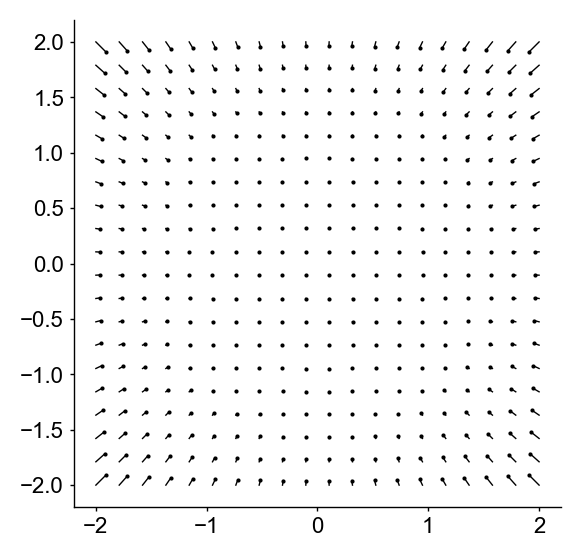

In [112]:
fig, ax = plt.subplots(figsize = (3, 3,))
vectorfield(ax, x, f(x), scale = 0.2, color = 'k')
plotter.finalize(fig, None)

In [113]:
n_traj = 50
len_traj = 100
h = np.zeros([n_traj, len_traj, 2])
h[:, 0] = np.random.randn(n_traj, 2)
for i in range(1, len_traj):
    h[:, i] = f(h[:, i - 1])

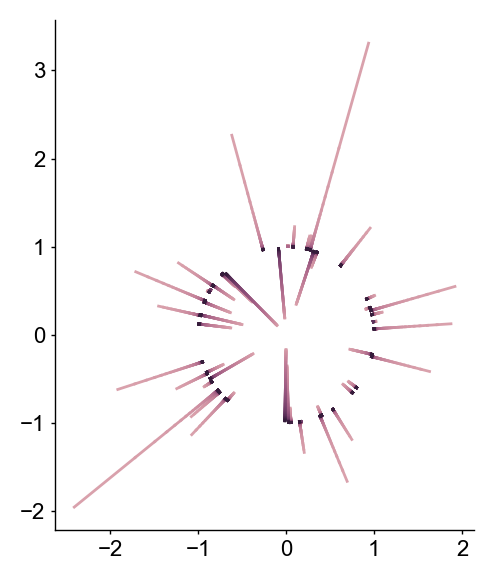

In [115]:
fig, ax = plt.subplots(figsize = (3, 3,))
pal = colors.ch0(len_traj)
for i in range(len_traj - 1):
    ax.plot(*h[:, [i, i+1]].T, color = pal[i])
ax.set_aspect(1.)
plotter.finalize(fig, None)

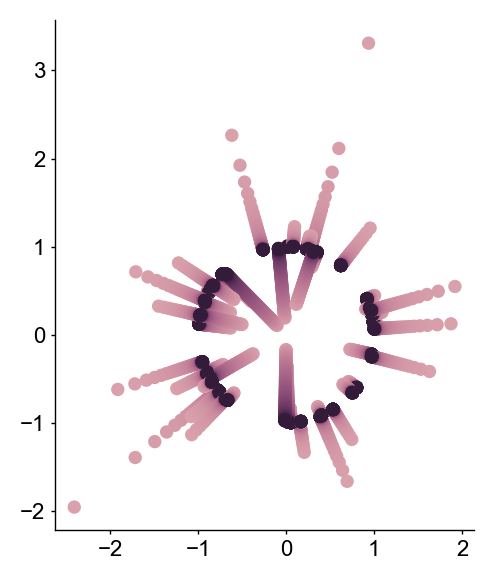

In [116]:
fig, ax = plt.subplots(figsize = (3, 3,))
pal = colors.ch0(len_traj)
ax.scatter(h[..., 0].ravel(), h[..., 1].ravel(), color = np.tile(pal[None], [n_traj, 1, 1]).reshape(-1, 3))
ax.set_aspect(1)
plotter.finalize(fig, None)

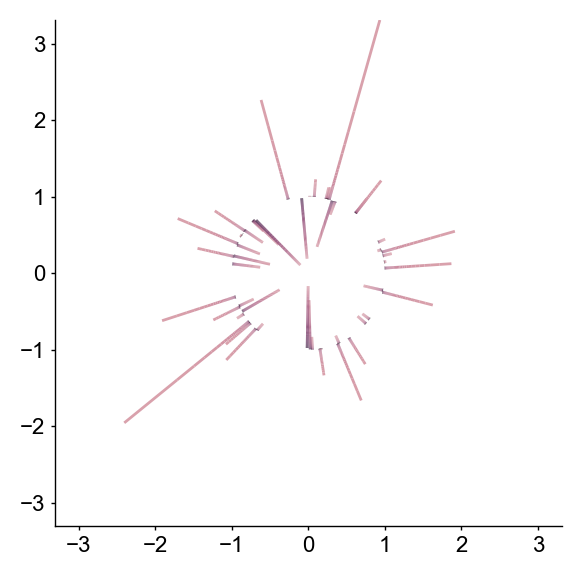

In [122]:
fig, ax = plt.subplots(figsize=(3, 3))
sliding = (
    np.lib.stride_tricks.sliding_window_view(h, 2, axis=1)
    .transpose(0, 1, 3, 2)
    .reshape(-1, 2, 2)
)
c = np.tile(pal[None, :-1], [n_traj, 1, 1]).reshape(-1, 3)
ax.add_artist(LineCollection(sliding, colors=c))
ax.set_aspect(1)
vrng = abs(h).max()
ax.set_xlim(-vrng, vrng)
ax.set_ylim(-vrng, vrng)
plotter.finalize(fig, None)

#### detect which elements of omega limit set are fixed points

In [134]:
n_traj = 50
len_traj = 100
h = th.zeros([n_traj, len_traj, 2])
h[:, 0] = th.randn(n_traj, 2)
for i in range(1, len_traj):
    h[:, i] = f(h[:, i - 1])

h = h.numpy()

In [142]:
def is_converging(histories, window = 20, thresh = 1e-2):
    """
    histories : (..., t, N)
    Returns
    -------
    is_converging : bool (...,)

    """
    histories = histories[..., -window:, :]
    magnitudes = la.norm(np.diff(histories, axis = -2), axis = -1)
    decreasing = np.all(np.diff(magnitudes) <= 0, axis = -1)
    small = magnitudes[:, -1] < thresh
    return small & decreasing



In [143]:
# all should be approaching a fixed point for these toy dynamics
is_converging(h)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

#### omega set jacobians

In [123]:
n_traj = 50
len_traj = 100
h = th.zeros([n_traj, len_traj, 2])
h[:, 0] = th.randn(n_traj, 2)
for i in range(1, len_traj):
    h[:, i] = f(h[:, i - 1])
h_omega = h[:, -1]

J = th.stack([
    th.autograd.functional.jacobian(f, h)
    for h in h_omega
])
Jl, Jv = th.linalg.eig(J)

In [125]:
Jl

tensor([[1.0000+0.j, 0.9334+0.j],
        [0.9335+0.j, 1.0001+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [0.9336+0.j, 1.0001+0.j],
        [0.9334+0.j, 1.0000+0.j],
        [1.0002+0.j, 0.9340+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [1.0000+0.j, 0.9334+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [0.9332+0.j, 1.0000+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [0.9337+0.j, 1.0001+0.j],
        [1.0000+0.j, 0.9334+0.j],
        [1.0001+0.j, 0.9335+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [1.0001+0.j, 0.9336+0.j],
        [0.9342+0.j, 1.0003+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [0.9334+0.j, 1.0000+0.j],
        [1.0001+0.j, 0.9335+0.j],
        [0.9333+0.j, 1.0000+0.j],
        [0.9334+0.j, 1.0000+0.j],
        [1.0000+0.j, 0.9333+0.j],
        [1.000